In [ ]:
import pandas as pd
import requests
import zipfile
import io
import os
import csv
import ctypes as ct
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns
import QuantLib as ql

from bgs.load_bgs_amounts import load_bgs_amounts
from bgs.load_gilt_details import load_csv_blocks
from bgs.load_bgs_prices import load_prices
from bgs.gilt_analytics import gilt_yield
from bgs.linker_analytics import linker_real_yield

In [2]:
def clean_date(bgs_index):
    if re.match(r'^\d{2}\s\w{3}\s+\d{4}$', bgs_index):
        return pd.to_datetime(bgs_index, format="%d %b %Y", errors='coerce')
    else:
        return pd.to_datetime(bgs_index)

def clean_percentage(x):
    if x.strip() in ['Variable','Floating']:
        return x
    try:
        x = float(x)
    except (ValueError, TypeError):
        units, fractions = x.split(' ')
        num, denom = map(float, fractions.split('/'))
        x = float(units) + num / denom
        print(x)
    return x

In [3]:
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

conv = tables['Conventionals']
conv.replace("Redeemed", "", inplace=True)
conv = conv.apply(pd.to_numeric, errors='coerce')
conv.fillna(0, inplace=True)
conv.index = pd.Index([clean_date(x) for x in list(conv.index)]).to_period('M').to_timestamp('M')

old = tables['Calculated indexed nominal Old-style']
old.replace("Redeemed", "", inplace=True)
old = old.apply(pd.to_numeric, errors='coerce')
old.fillna(0, inplace=True)
old.index = pd.Index([clean_date(x) for x in list(old.index)]).to_period('M').to_timestamp('M')

new = tables['Calculated indexed nominal New-style']
new.replace("Redeemed", "", inplace=True)
new = new.apply(pd.to_numeric, errors='coerce')
new.fillna(0, inplace=True)
new.index = pd.Index([clean_date(x) for x in list(new.index)]).to_period('M').to_timestamp('M')

new_no_idx = tables['Index-linked New-style']
new_no_idx.replace("Redeemed", "", inplace=True)
new_no_idx = new_no_idx.apply(pd.to_numeric, errors='coerce')
new_no_idx.fillna(0, inplace=True)
new_no_idx.index = pd.Index([clean_date(x) for x in list(new_no_idx.index)]).to_period('M').to_timestamp('M')


In [4]:
price_df=load_prices("downloads/BGSPrices.csv")
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')
for text in ['Amalgamated', 'Redeemed', 'redeemed']:
    price_df = price_df.replace(text, 0)
price_df = price_df.replace('missing', None)
price_df = price_df.ffill(axis=0)
price_df = price_df.fillna(0)

/tmp/ipykernel_3051/736416946.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.replace(text, 0)
/tmp/ipykernel_3051/736416946.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.ffill(axis=0)


In [5]:
details = load_csv_blocks("downloads/BGSDetails.csv")

details.keys()

dict_keys(['Conventionals', 'Index-Linked Old-style', 'Index-Linked New-style'])

In [6]:

conv_details = details['Conventionals']
conv_details['%'] = conv_details['%'].apply(clean_percentage)

new_details = details['Index-Linked New-style']
new_details['%'] = new_details['%'].apply(clean_percentage)

old_details = details['Index-Linked Old-style']
old_details['%'] = old_details['%'].apply(clean_percentage)


3.75


In [7]:
last = '2025-04-30'

In [8]:
linkers = new.loc[last, new.loc[last] !=0].reset_index()['index'].to_list()
linkers[0]

'55280'

In [9]:
last_price = price_df.loc[last, [int(x) for x in linkers]]
principal = new.loc[last, linkers]

In [10]:
principal.index = principal.index.astype(int)
principal.name = 'balance_outstanding'
last_price.name = 'price'

In [11]:
data_set_april = last_price.reset_index().merge(principal.reset_index(), on='index')
data_set_april.rename(columns={'index': 'Sequence'}, inplace=True)

In [12]:
#Average Price
(data_set_april['balance_outstanding']*data_set_april['price']).sum()/data_set_april['balance_outstanding'].sum()

np.float64(80.75752808115158)

In [13]:
data_set_april.head()

,Sequence,price,balance_outstanding
0,55280,99.822,20527.9
1,55300,103.049,28768.8
2,55310,99.967,25309.3
3,55320,99.130,25654.0
4,55340,97.042,15437.8


In [14]:
new_details['Sequence'] = new_details['Sequence'].astype(int)

In [15]:
len([x for x in new_details['Sequence'] if x in [int(y) for y in linkers]])

32

In [16]:
len(linkers)

32

In [17]:
new_details.columns

Index(['Sequence', 'Inst Code', 'Sedol', 'ISIN Code', '%', 'Stock', 'Suffix',
       'Special features', 'First year', 'Last year', 'Issue date',
       'First coupon payable on date', 'Earliest redemption date',
       'Latest redemption date', 'A (B, C ...) stock merged on date',
       'Actually redeemed', 'Frequency', 'Payment date 1', 'Payment date 2',
       'Payment date 3', 'Payment date 4', 'First coupon',
       'IL coupon rounding', 'IL redemption rounding', 'Indexing lag',
       'Base month', 'Base RPI', 'Number of calls', 'Call payment 1',
       'due on 1', 'Call payment 2', 'due on 2', 'Call payment 3', 'due on 3',
       'Call payment 4', 'due on 4', ''],
      dtype='object')

In [18]:
date_variables = ["Latest redemption date","Issue date","First coupon payable on date",]
static_variables = ['%', "Frequency","Sequence",'ISIN Code']+date_variables
data_set_april = data_set_april.merge(new_details[static_variables].set_index("Sequence"), on='Sequence', how='inner')
for date_var in date_variables:
    data_set_april[date_var] = data_set_april[date_var].apply(clean_date)
data_set_april.head()

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
0,55280,99.822,20527.9,0.125,2,GB00BYY5F144,2026-03-22,2015-07-16,2015-09-22
1,55300,103.049,28768.8,1.250,2,GB00B128DH60,2027-11-22,2006-04-26,2006-11-22
2,55310,99.967,25309.3,0.125,2,GB00BZ1NTB69,2028-08-10,2018-06-21,2019-02-10
3,55320,99.130,25654.0,0.125,2,GB00B3Y1JG82,2029-03-22,2011-11-23,2012-03-22
4,55340,97.042,15437.8,0.125,2,GB00BNNGP551,2031-08-10,2021-01-28,2021-08-10


In [19]:
(data_set_april['balance_outstanding']*data_set_april['%']).sum()/data_set_april['balance_outstanding'].sum()

np.float64(0.5083613626563174)

<Axes: ylabel='Frequency'>

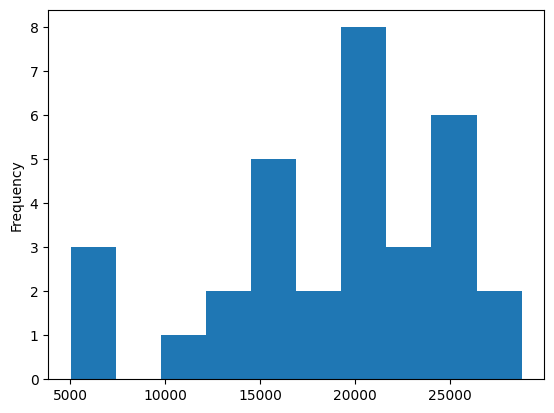

In [20]:
data_set_april['balance_outstanding'].plot(kind='hist')

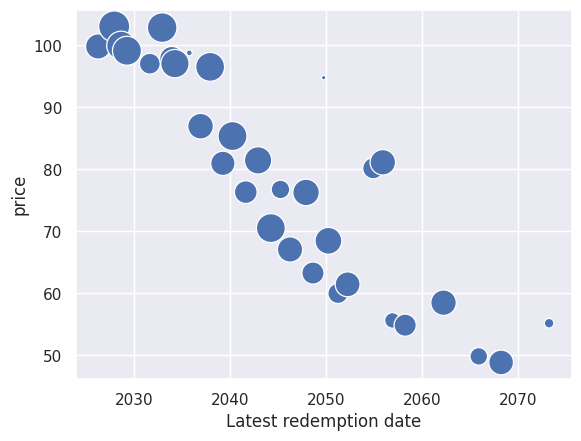

In [21]:
sns.set_theme(style="darkgrid")

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(
    data=data_set_april,
    x="Latest redemption date",
    y="price",
    size="balance_outstanding",
    legend=False,
    sizes=(10, 500)
)

# show the graph
plt.show()

In [22]:
august = "2022-08-31"
september = "2022-09-30"
december = "2022-12-31"

In [23]:
liz_linkers  = new.loc[august, new.loc[august] !=0].reset_index()['index'].to_list()

In [24]:
august_price = price_df.loc[august, [int(x) for x in liz_linkers]]
september_price = price_df.loc[september, [int(x) for x in liz_linkers]]
december_price = price_df.loc[december, [int(x) for x in liz_linkers]]

In [25]:
last_price.name='Apr-2025'
august_price.name='Aug-2022'
september_price.name='Sep-2022'
december_price.name='Dec-2022'

In [26]:
history = pd.concat([last_price, august_price, september_price, december_price], axis=1)

In [27]:
history = history.replace(0.000, np.nan)
history

,Apr-2025,Aug-2022,Sep-2022,Dec-2022
55280,99.822,108.205,101.036,100.937
55300,103.049,116.836,106.484,105.846
55310,99.967,111.371,100.421,100.252
55320,99.130,111.793,100.102,99.826
55340,97.042,115.234,101.326,100.660
55350,102.862,127.450,111.520,110.980
55360,97.882,NaN,NaN,NaN
55375,97.053,122.230,106.790,105.190
55380,98.790,NaN,NaN,NaN
55385,86.960,116.210,102.270,96.820


In [28]:
history = history.reset_index().rename(columns={'index':'Sequence'})
history = history.merge(new_details[['Sequence','Latest redemption date']], on='Sequence', how='left')

In [29]:
history['Latest redemption date'] = history['Latest redemption date'].apply(clean_date)
history.set_index('Latest redemption date', inplace=True)
history.drop(columns=['Sequence'], inplace=True)


<Axes: xlabel='Latest redemption date'>

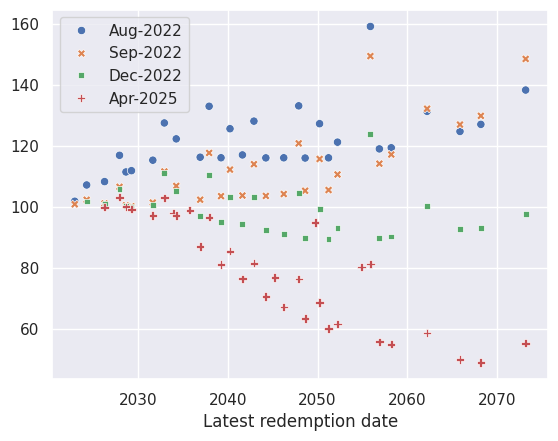

In [30]:
sns.scatterplot(data=history[['Aug-2022','Sep-2022','Dec-2022','Apr-2025']])

In [31]:
higher_prices = [55360,55380, 55465,55485, 55500]

In [32]:
data_set_april.loc[data_set_april['Sequence'].isin(higher_prices)]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
6,55360,97.882,19168.4,0.750,2,GB00BMF9LJ15,2033-11-22,2023-06-28,2023-11-22
8,55380,98.790,5395.0,1.125,2,GB00BT7HZZ68,2035-09-22,2025-01-29,2025-09-22
20,55465,94.790,5026.1,1.875,2,GB00BT7J0134,2049-09-22,2025-03-12,2025-09-22
24,55485,80.170,15663.1,1.250,2,GB00BPSNBG80,2054-11-22,2024-03-14,2024-05-22
25,55500,81.140,20846.3,1.250,2,GB00B0CNHZ09,2055-11-22,2005-09-23,2006-05-22


In [33]:
data_set_april.loc[data_set_april['Issue date'] == data_set_april['Issue date'].min()]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
25,55500,81.14,20846.3,1.25,2,GB00B0CNHZ09,2055-11-22,2005-09-23,2006-05-22


<Axes: >

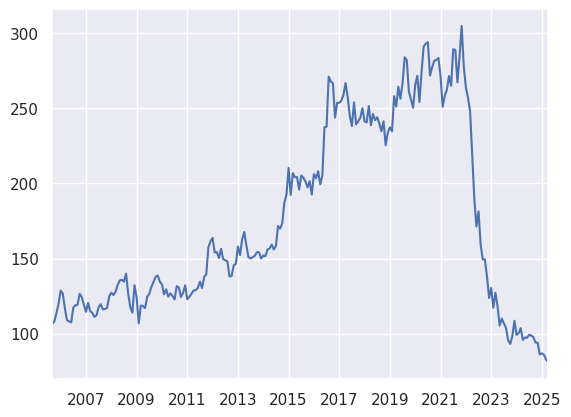

In [34]:
price_df[55500]['2005-09-30':].plot()

In [35]:
data_set_april.loc[data_set_april['Latest redemption date'] == data_set_april['Latest redemption date'].max()]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
31,55800,55.19,6865.9,0.125,2,GB00BM8Z2W66,2073-03-22,2021-11-24,2022-03-22


In [ ]:



df_ons_rpi = pd.read_csv("downloads/ONSRPI.csv", header=7, names=["date", "RPI"])
monthly_start = df_ons_rpi[df_ons_rpi["date"] == "1987 JAN"].index[0]
ONS_RPI_INDEX = df_ons_rpi.iloc[monthly_start:].copy()

df_infl = pd.ExcelFile("downloads/GLC Inflation month end data_2025 to present.xlsx")
DF_SPOT = pd.read_excel(
    df_infl, sheet_name="4. spot curve", header=3, skiprows=[4]
).set_index("years:")
DF_SPOT[50] = DF_SPOT[40]

def get_real_yield(row):
    ["Latest redemption date","Issue date","First coupon payable on date",]

    issue_dt = row["Issue date"].strftime("%d/%m/%Y")
    first_coupon_dt = row["First coupon payable on date"].strftime("%d/%m/%Y")
    maturity_dt = row["Latest redemption date"].strftime("%d/%m/%Y")
    coupon = row["%"]
    clean_price = row["price"]

    inflation_spot_curve = DF_SPOT.copy()
    monthly_rpi_index = ONS_RPI_INDEX.copy()

    previous_month_end = (
        pd.to_datetime(last, format="%Y-%m-%d") + pd.offsets.MonthEnd(-1)
    ).strftime("%Y-%m-%d")
    infl_curve = inflation_spot_curve.loc[
        inflation_spot_curve.index == previous_month_end
    ].to_dict(orient="list")

    inflation_quotes = [
        (ql.Period(int(key), ql.Years), value[0])
        for key, value in infl_curve.items()
        if key * 2 // 2 == key
    ]

    today = ql.Date(last, "yyyy-MM-dd")
    issue_date = ql.Date(issue_dt, "dd/MM/yyyy")
    first_coupon_date = ql.Date(first_coupon_dt, "dd/MM/yyyy")
    maturity_date = ql.Date(maturity_dt, "dd/MM/yyyy")
    notional = 100
    fixed_rates = [coupon/100]

    r = linker_real_yield(
        trade_date=today,
        ons_rpi_idx=monthly_rpi_index,
        settlement_days=1,
        inflation_quotes=inflation_quotes,
        notional=notional,
        issue_date=issue_date,
        maturity_date=maturity_date,
        fixedRates=fixed_rates,
        clean_price=clean_price,
        first_coupon_date=first_coupon_date,
    )
    
    return round(r,8)

In [37]:
data_set_april['real_yield']=data_set_april.apply(get_real_yield, axis=1)

<Axes: xlabel='Latest redemption date'>

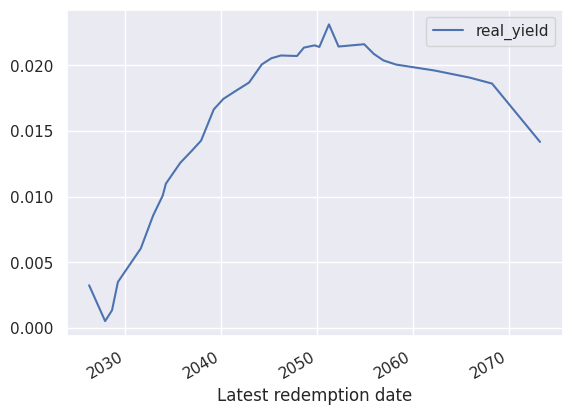

In [38]:
data_set_april.plot(x='Latest redemption date', y='real_yield')

<Axes: xlabel='Issue date', ylabel='real_yield'>

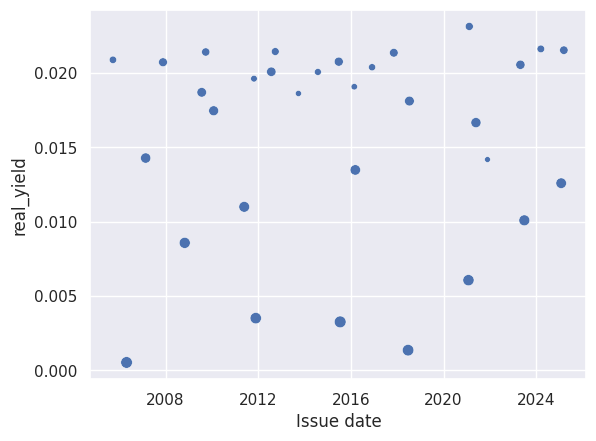

In [39]:
sns.scatterplot(
    data=data_set_april,
    x="Issue date",
    y="real_yield",
    size="Latest redemption date",
    legend=False,)


In [40]:
data_set_april.loc[data_set_april['real_yield'] == data_set_april['real_yield'].max()]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,real_yield
22,55475,60.0,14788.9,0.25,2,GB00BNNGP882,2051-03-22,2021-02-10,2021-09-22,0.023118


In [41]:
data_set_april[data_set_april['Latest redemption date'] > '2051-03-31']

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,real_yield
23,55480,61.46,20128.9,0.250,2,GB00B73ZYW09,2052-03-22,2012-09-26,2013-03-22,0.021430
24,55485,80.17,15663.1,1.250,2,GB00BPSNBG80,2054-11-22,2024-03-14,2024-05-22,0.021607
25,55500,81.14,20846.3,1.250,2,GB00B0CNHZ09,2055-11-22,2005-09-23,2006-05-22,0.020874
26,55525,55.64,10630.2,0.125,2,GB00BYVP4K94,2056-11-22,2016-11-30,2017-05-22,0.020376
27,55550,54.87,16865.2,0.125,2,GB00BP9DLZ64,2058-03-22,2014-07-30,2015-03-22,0.020057
28,55600,58.50,20849.9,0.375,2,GB00B4PTCY75,2062-03-22,2011-10-26,2012-03-22,0.019606
29,55650,49.84,12292.0,0.125,2,GB00BD9MZZ71,2065-11-22,2016-02-24,2016-05-22,0.019065
30,55700,48.86,19881.4,0.125,2,GB00BDX8CX86,2068-03-22,2013-09-26,2014-03-22,0.018611
31,55800,55.19,6865.9,0.125,2,GB00BM8Z2W66,2073-03-22,2021-11-24,2022-03-22,0.014169


In [42]:
# data_set_april[data_set_april['Latest redemption date'] > '2051-03-31']
data_set_april.sort_values(by='%', ascending=False).head()

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,real_yield
20,55465,94.790,5026.1,1.875,2,GB00BT7J0134,2049-09-22,2025-03-12,2025-09-22,0.021521
1,55300,103.049,28768.8,1.250,2,GB00B128DH60,2027-11-22,2006-04-26,2006-11-22,0.000524
24,55485,80.170,15663.1,1.250,2,GB00BPSNBG80,2054-11-22,2024-03-14,2024-05-22,0.021607
5,55350,102.862,26595.4,1.250,2,GB00B3D4VD98,2032-11-22,2008-10-29,2009-05-22,0.008565
25,55500,81.140,20846.3,1.250,2,GB00B0CNHZ09,2055-11-22,2005-09-23,2006-05-22,0.020874


In [43]:
data_set_april[data_set_april['price']<80]['balance_outstanding'].sum()

np.float64(260758.39999999997)

In [44]:
def calculate_lme_balance(row):
    if row['price'] > 80:
        return row['balance_outstanding']
    else:
        return row['balance_outstanding'] * row['price']/100

def calculate_lme_real_yield(row):
    if row['Latest redemption date'] > pd.to_datetime('2051-03-31', format="%Y-%m-%d"):
        return 0.0215
    else:
        return row['real_yield']
    
def calculate_lme_coupon(row):
    if row['Latest redemption date'] > pd.to_datetime('2051-03-31', format="%Y-%m-%d"):
        return 2.15
    else:
        return row['%']

data_set_april['lme_balance'] = data_set_april.apply(calculate_lme_balance, axis=1)
data_set_april['lme_real_yield'] = data_set_april.apply(calculate_lme_real_yield, axis=1)
data_set_april['lme_coupon'] = data_set_april.apply(calculate_lme_coupon, axis=1)

In [45]:
infl = 0.035
data_set_april['uplift'] = data_set_april['balance_outstanding']*infl
data_set_april['cash_interest'] = data_set_april['balance_outstanding']*data_set_april['%']/100

data_set_april['new_uplift'] = data_set_april['lme_balance']*infl
data_set_april['new_cash_interest'] = data_set_april['lme_balance']*data_set_april['lme_coupon']/100

print(data_set_april['uplift'].sum() + data_set_april['cash_interest'].sum(), data_set_april['new_uplift'].sum() + data_set_april['new_cash_interest'].sum())

24400.398750000004 22358.58295389


In [46]:
data_set_april['mat_year'] = data_set_april['Latest redemption date'].dt.year
data_set_april['mat_decade'] = (data_set_april['mat_year'] // 10 * 10)
data_set_april['issue_year'] = data_set_april['Issue date'].dt.year
data_set_april['uplift_chg'] = data_set_april['new_uplift'] - data_set_april['uplift']
data_set_april['cash_interest_chg'] = data_set_april['new_cash_interest'] - data_set_april['cash_interest']
data_set_april['interest_chg'] = data_set_april['cash_interest_chg'] + data_set_april['uplift_chg']

In [47]:
data_set_april[['uplift','new_uplift','uplift_chg']]

,uplift,new_uplift,uplift_chg
0,718.4765,718.476500,0.000000
1,1006.9080,1006.908000,0.000000
2,885.8255,885.825500,0.000000
3,897.8900,897.890000,0.000000
4,540.3230,540.323000,0.000000
5,930.8390,930.839000,0.000000
6,670.8940,670.894000,0.000000
7,865.2000,865.200000,0.000000
8,188.8250,188.825000,0.000000
9,737.4290,737.429000,0.000000


<Axes: title={'center': 'Aggregated Financial Metrics by Maturity Decade'}, xlabel='mat_decade'>

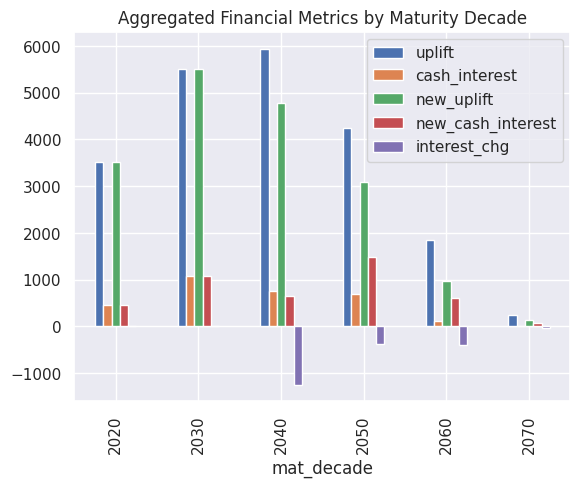

In [48]:
data_set_april.groupby('mat_decade').agg(
    {
        'uplift':'sum',
        'cash_interest':'sum',
        'new_uplift':'sum',
        'new_cash_interest':'sum',
        'interest_chg':'sum'
    }).plot(kind='bar', title='Aggregated Financial Metrics by Maturity Decade')